In [1]:
# Import functions 
import sys
sys.path.insert(0, '..')
from utils import *

# Time limit for debugging video
time_limit = 10    

In [2]:
# Starter code class that handles the fancy stuff. No need to modify this! 
class Racecar:
    SCAN_TOPIC = "/scan"
    IMAGE_TOPIC = "/camera"
    DRIVE_TOPIC = "/drive"
    
    def __init__(self):
        self.sub_scan = rospy.Subscriber(self.SCAN_TOPIC, LaserScan, callback=self.scan_callback)
        self.sub_image = rospy.Subscriber(self.IMAGE_TOPIC, Image, callback=self.image_callback)
        self.pub_drive = rospy.Publisher(self.DRIVE_TOPIC, AckermannDriveStamped, queue_size=1)
        self.last_drive = AckermannDriveStamped()
    
    def image_callback(self, msg):
        self.last_image = msg.data
        
    def show_last_image(self):
        im = np.fromstring(self.last_image,dtype=np.uint8).reshape((480,-1,3))[...,::-1]
        return im
        
    def scan_callback(self, msg):
        self.last_scan = msg.ranges
        
    def drive(self, speed, angle):
        msg = AckermannDriveStamped()
        msg.drive.speed = speed
        msg.drive.steering_angle = angle
        self.last_drive = msg
    
    def stop(self):
        self.drive(0, 0) #self.last_drive.drive.steering_angle)
    
    def look(self):
        return self.last_image
    
    def scan(self):
        return self.last_scan
    
    def run(self, func, time_limit=10):
        r = rospy.Rate(60)
        t = rospy.get_time()
        cap = cv2.VideoCapture(2)
        while rospy.get_time() - t < time_limit and not rospy.is_shutdown():
            func(cap.read()[1])
            self.pub_drive.publish(self.last_drive)
            r.sleep()
        cap.release()
        print("END OF ROSPY RUN")
        self.stop()
        self.pub_drive.publish(self.last_drive)
        time.sleep(0.1)
    
rospy.init_node('racecar')
rc = Racecar()
print('ROS node started successfully')

ROS node started successfully


# Cone Following

<p style='font-size:1.75rem;line-height:1.5'>
    Today's task will involve using our previous knowledge of contours, masking, and other opencv techniques to identify, follow, and park/stop a foot away from the cone. At the end, we will use cone following to also navigate an obstacle course. 
    </p>

# Part 1: Cone Identification

<p style='font-size:1.75rem;line-height:1.5'>
    In this section, we will be identifying cones by masking and finding contours in the image.
    </p>

### 1a. Parameters

<p style='font-size:1.75rem;line-height:1.5'>
    We have provided some useful parameters for debugging your functions:
    <ul style='font-size:1.75rem;line-height:1.5'>
        <li><code>MIN_SIZE (int):</code> the minimum required size of a detected contour to be considered a potential cone</li>
        <li><code>VIDEO (bool):</code> toggle between showing the camera video (<code>True</code>) or camera image (<code>False</code>)</li>
        <li><code>SAVE_IMAGE (bool):</code> saves images into the "pictures" folder to be used for HSV thresholding</li>
    </ul>
    </p>

In [3]:
MIN_SIZE = 100 
VIDEO = False  
SAVE_IMAGE = False

### 1b. Get the HSV Values of the Cone

<p style='font-size:1.75rem;line-height:1.5'>
    Set the HSV lower and upper bounds here to detect the cone!
    <ol style='font-size:1.75rem;line-height:1.5'>
        <li>First use sample cone images to get the initial HSV bounds. The sample images are located in the <code>test_images</code> folder of the <code>cone following</code> lab.</li>
        <li>Then, use <code>hsv_select</code> to mask for the cone!</li>
    </ol>
    </p>
    
<img src="cone_mask.png" width="100" height="150"> 

In [4]:
HSV_LOWER = np.array([2, 60, 232])
HSV_UPPER = np.array([20, 255, 255])

### 1c. <code>find_contours</code>

<p style='font-size:1.75rem;line-height:1.5'>
    This function finds and returns the contours and mask of <code>img</code>.
    </p>

In [5]:
def find_contours(img):
    # TASK #1: Convert the img to from bgr to hsv.
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # TASK #2: Mask the image using hsv_lower and hsv_upper. Save as 'mask'.
    mask = cv2.inRange(img_hsv, HSV_LOWER, HSV_UPPER)
    
    # TASK #3: Find the contours in the image. Save as 'contours'.
    contours = cv2.findContours(mask, 3, 2)[1]
    
    return contours, mask

### 1d. <code>check_contours_exist</code>

<p style='font-size:1.75rem;line-height:1.5'>
    This function makes sure that there are large enough contours in the image.
    </p>

In [6]:
def check_contours_exist(contours):
    greatest_contour = None
    
    # TASK #1: If the contours list is empty, return (False, greatest_contour)
    if contours == [] or contours is None:
        print('no contour')
        return (False, greatest_contour)
    
    # TASK #2: Call 'find_greatest_contour'. 
    #          This function returns 'greatest_contour', and accepts one argument: 'contours'.
    greatest_contour = find_greatest_contour(contours)
    
    # TASK #3: If the contour area of the greatest contour is smaller than 'MIN_SIZE', return (False, greatest_contour)
    contour_area = cv2.contourArea(greatest_contour)
    if contour_area < MIN_SIZE:
        print('contours too small: {}'.format(contour_area))
        return (False, greatest_contour) 
    
    return (True, greatest_contour)

### 1e. <code>draw_contours</code>
<p style='font-size:1.75rem;line-height:1.5'>
    This function draws either regular or rectangle contours around a detected object. The returned images look something like this:
    </p>
    
<img src="cone_contour.png" alt="cone_contour" style="width: 500px;"/>
<img src="cone_rectangle.png" alt="cone_rectangle" style="width: 500px;"/>

In [7]:
def draw_contours(img, greatest_contour, mask):
    # TASK #1: Get the color mask of the image
    color_mask = cv2.bitwise_and(img, img, mask=mask)
    
    # TASK #2: Draw the greatest contour on img. Use either drawContours or cv2.rectangle.
    cv2.drawContours(img, [greatest_contour], 0, (0,255, 0), 2)    # draw contour
    
    #x,y,w,h = cv2.boundingRect(cnt)                               # draw rectangle
    #cv2.rectangle(img, (x,y),(x+w,y+h),(0,255, 0),4)
    
    return img

### 1f. Let's test our functions!

<p style='font-size:1.75rem;line-height:1.5'>
    Run the cell block below. Modify the hsv bounds and parameters from above to find the best values for your racecar! The better the parameters, the better your car will run!
    </p>
    
<p style='font-size:1.75rem;line-height:1.5'>    
    Make sure that our function can identify the cone and draw a bounding box around it.
    </p>

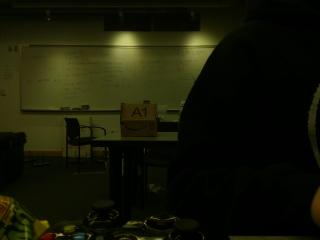

no contour


In [8]:
last_time = time.time()
def identify_cone(img):
    global last_time
    
    # run student helper functions
    contours, mask = find_contours(img)
    contours_exist, greatest_contour = check_contours_exist(contours)
    if contours_exist:
        img = draw_contours(img, greatest_contour, mask)
    
    # decrease frames per sec 
    if VIDEO and time.time()-last_time>=1:
        show_frame(img)
        last_time = time.time()
    
    return img

# display image or video
if VIDEO: show_identified_video(identify_cone, time_limit, rc)
else: show_identified_image(identify_cone, SAVE_IMAGE) 

# Part 2: Cone Following

<p style='font-size:1.75rem;line-height:1.5'>
    Now that our car can identify the cone, let us have our car follow the cone until it is one foot away from the cone. 
    </p>

### 2a. Parameters

<p style='font-size:1.75rem;line-height:1.5'>
    We have provided some useful parameters for debugging your functions:
    <ul style='font-size:1.75rem;line-height:1.5'>
        <li><code>DRIVE_SPEED (float):</code> the speed of your racecar</li>
        <li><code>SCREEN_CENTER (float):</code> the camera is slightly shifted. Use this to re-set the center pixel location to reset your output image.</li>
        <li><code>FORWARD_SIZE (int):</code> size that means the contour is too small, making the car drive forwards</li>
        <li><code>BACKWARD_SIZE (int):</code> size that means the contour is too large, making the car drive backwards</li>
        <li><code>ANGLE_GAIN (float):</code> </li>
    </ul>
    </p>

In [9]:
DRIVE_SPEED = 0.215    # should be a float between 0 to 1
SCREEN_CENTER = 320.0  # pixel x-axis

FORWARD_SIZE = 12000   # contour small, move forwards
BACKWARD_SIZE = 30000  # contour large, move backwards

ANGLE_GAIN = 0.5     

### 2b. <code>get_speed</code>

<p style='font-size:1.75rem;line-height:1.5'>
    <code>get_speed</code> determines if the car will drive forwards or backwards depending on how close the car is to the cone (aka how big the contour is). If the car is within a specific range (aka within 1 ft of the cone), then the car will not drive. This function returns the speed commands for the car.
    </p>

In [10]:
def get_speed(contour):
    speed, angle = [0, 0]
    
    # TASK #1: Get the contour area of 'contour'
    contour_area = cv2.contourArea(contour)
    
    # TASK #2: If the contour area is larger than the backward_size, set speed to the -drive_speed.
    #          If the contour area is smaller than the forward_size, set speed to drive_speed.
    if contour_area > BACKWARD_SIZE:
        print('negative speed: {}'.format(contour_area))
        speed = -DRIVE_SPEED
    elif contour_area < FORWARD_SIZE:
        print('positive speed: {}'.format(contour_area))
        speed = DRIVE_SPEED
        
    return speed

### 2c. get_angle

### <code>get_angle</code>

<p style='font-size:1.75rem;line-height:1.5'>
    This function returns the turn angle of the car. When the cone is at the center of the screen, the car and cone should be aligned. 
    </p>
    
<p style='font-size:1.75rem;line-height:1.5'>
    <b>Discuss with your group members some ways we might calculate the angle for the car to move.</b> 
    </p>

<p style='font-size:1.75rem;line-height:1.5'>
    <ul style='font-size:1.75rem;line-height:1.5'>
        <li>From the 4 numbers, we find the cone position: <code>(x+w/2, y+h/2)</code></li>
        <li>calculate the ratio that the cone is away from the center of the screen: 
            <br><code>ratio = (cone position - center of screen)/center of screen</code> </li>
        <li>If ratio is greater than the <code>error</code> allowed for the cone to be away from the center, multiply the ratio by a <code>gain</code> to calculate </li>
        <li>We don't have to worry about <code>-/+</code> angle because ratio will determine this with cone position - center of screen</li>
        <li>We will give starting numbers for error and constant, but they should be fine-tuned later.</li>
    </ul>
    </p>

### <code>error</code>

<p style='font-size:1.75rem;line-height:1.5'>
    The error variable will allow the cone to diverge from the center of the screen until the car moves too far that the ratio exceeds the error allowed. 
    </p>

<p style='font-size:1.75rem;line-height:1.5'>
    <b>Discuss with group members possibly why we might need an error, what happens when error is big, and what other variables error is dependent upon (and why).</b> 
    </p>

<p style='font-size:1.75rem;line-height:1.5'>
    <b style="color:red">Discussion Answers:</b>
    <ol style='font-size:1.75rem;line-height:1.5'>
      <li>If the error is too small, the car might be constantly turning to adjust.</li>
      <li>When the error is too large, the car may continue at an angle that will make it miss seeing the cone.</li>
      <li>Error is slightly dependent on the car speed, min_size, and distance away from cone to stop followin
        <ul>
            <li>the faster the car speed, the smaller error we should allow</li>
            <li>the smaller-sized a cone we allow our car to follow, the smaller error we should allow</li>
        </ul>
        </li>    
    </ol>  
    </p>

### <code>gain</code>

<p style='font-size:1.75rem;line-height:1.5'>
    The gain and ratio will be multiplied to get the angle.
    </p>

<p style='font-size:1.75rem;line-height:1.5'>
    <b>Discuss with group members on what the min/max of <code>ration*gain</code> means, what we want the min/max to be, and which variables the constant is possibly dependent upon.</b> 
    </p>
    
<p style='font-size:1.75rem;line-height:1.5'>
    <b style="color:red">Discussion Answers:</b>
    <ol>
      <li><p style='font-size:1.75rem;line-height:1.5'>the min/max of (<code>ratio*gain</code>) will be the min/max turn angle </li>
  <li><p style='font-size:1.75rem;line-height:1.5'>the actual min/max may vary from group to group</li>
  <li><p style='font-size:1.75rem;line-height:1.5'>constant is slightly dependent on the error and its dependencies </li>  
    </ol>  
    </p>
    

In [11]:
def get_angle(contour, res):
    speed, angle = res
    M = cv2.moments(contour)
    if M['m00'] != 0.0:
        contour_moment = int(M['m10']/M['m00'])
        
        ## ------ STUDENT CODE HERE ------ ##
        ratio = 0 
        gain = -abs(ANGLE_GAIN)     # negative
        if speed < 0:
            gain = abs(ANGLE_GAIN)  # positive
        error = contour_moment - SCREEN_CENTER*1.0
        if abs(error) > 20 and SCREEN_CENTER != 0:
            ratio = error/SCREEN_CENTER
            angle = ratio*gain 
            return angle  
        ## ------------------------------- ##
        
    return angle

### 2d. Let's test our functions!

<p style='font-size:1.75rem;line-height:1.5'>
    Run the cell block below. Modify the hsv bounds and parameters from above to find the best values for your racecar! The better the parameters, the better your car will run! 
    </p>

<p style='font-size:1.75rem;line-height:1.5'>
    For <code>cone_follow</code> function, we'll create a similar function to cone identification, except this time we will call the get_angle() function and have the car turn. Furthermore, we include a max_size in which if the cone seems too big, our car will move back and then stop when the cone size is max_size, like this:
    </p>
    
![cone_following.gif](cone_following.gif)

In [12]:
last_time = time.time()
def cone_follow(img):
    global last_time
    img = cv2.resize(img, (480, 640))
    
    speed, angle = [0, 0]
    
    # run student helper functions
    contours, mask = find_contours(img) 
    contours_exist, greatest_contour = check_contours_exist(contours)
    if (contours_exist is True) and (cv2.contourArea(greatest_contour) > MIN_SIZE):
        speed = get_speed(greatest_contour)
        angle = get_angle(greatest_contour, (speed, angle))
        contour_area = cv2.contourArea(greatest_contour)
        if speed == 0:
            print('Parked! {}'.format(contour_area))
        img = cv2.drawContours(img, [greatest_contour], 0, (0,255, 0), 2)
        rc.drive(speed, angle)
    
    # decrease frames per sec 
    if VIDEO and time.time()-last_time>=1:
        show_frame(img)
        last_time = time.time()
        
    return img
    
# too small, range to stop: min to max
rc.run(cone_follow, time_limit) 

no contour
no contour
no contour
contours too small: 0.0
contours too small: 0.0
contours too small: 1.0
contours too small: 0.0
contours too small: 2.5
contours too small: 63.5
contours too small: 83.0
contours too small: 96.5
contours too small: 97.5
positive speed: 101.0
positive speed: 102.5
positive speed: 101.5
positive speed: 106.5
positive speed: 109.0
positive speed: 130.5
positive speed: 125.0
positive speed: 156.0
positive speed: 174.0
positive speed: 184.5
positive speed: 186.5
positive speed: 175.5
positive speed: 216.5
positive speed: 170.5
positive speed: 182.0
positive speed: 185.0
positive speed: 209.0
positive speed: 198.0
positive speed: 188.5
positive speed: 205.5
positive speed: 215.5
positive speed: 192.0
positive speed: 169.0
positive speed: 191.5
positive speed: 184.5
positive speed: 197.0
positive speed: 198.0
positive speed: 155.0
positive speed: 203.0
positive speed: 795.0
positive speed: 1567.0
positive speed: 2216.0
positive speed: 3212.0
positive speed: 38


---



---



---



---


# Part 3: Cone Swerving (TODOOOOOO)

<p style='font-size:1.75rem;line-height:1.5'>
We will have a line of cones that are about 2-3 feet apart between them (we can adjust if needed). We want our car to go around the cones like such: 

<img src='https://banner2.kisspng.com/20180707/cxx/kisspng-traffic-cone-obstacle-course-line-area-obstacle-course-5b4100657e2ef8.7869525115309865975169.jpg' width='250' height='250'>
<p style='font-size:1.75rem;line-height:1.5'>
<b>Discuss possible methods with your partner.</b>

<p style='font-size:1.75rem;line-height:1.5'>
<b>Method 1</b> 

Steps:
<ol>
  <li><p style='font-size:1.75rem;line-height:1.5'>car follows largest cone until the cone is too big </li>
  <li><p style='font-size:1.75rem;line-height:1.5'>car turns and drives for a certain time so that last cone disappears from its field of vision or becomes too small. </li>
  <li><p style='font-size:1.75rem;line-height:1.5'>repeat step 1 until there are no cones left. </li>
</ol> 


<p style='font-size:1.75rem;line-height:1.5'>
<b>Method 2</b>
<p style='font-size:1.75rem;line-height:1.5'>
Steps:
<ol>
  <li><p style='font-size:1.75rem;line-height:1.5'>car turns a set angle to left (or right) first  </li>
  <li><p style='font-size:1.75rem;line-height:1.5'>car continues driving until the car is too far to the side of the screen </li>
  <li><p style='font-size:1.75rem;line-height:1.5'>car then turns in the other direction and continues the next cone is too far in the corner </li>
    <li><p style='font-size:1.75rem;line-height:1.5'>repeats</li>
</ol>     


<p style='font-size:1.75rem;line-height:1.5'>
<b>Discuss the pros and cons of each method.</b>
<img src='discussion_image.jpg' width='350' height='250'>
<b>Answer</b>
<p style='font-size:1.75rem;line-height:1.5'>
Method 1: 
<p style='font-size:1.75rem;line-height:1.5'>
<ul>
  <li><p style='font-size:1.75rem;line-height:1.5'>Pros: don't need to worry about distances between cones. </li>
  <li><p style='font-size:1.75rem;line-height:1.5'>Cons: may be unable to navigate tight obstacles and may be constantly adjusting as <b>the error must be tiny</b> </li>

</ul>  
<p style='font-size:1.75rem;line-height:1.5'>
Method 2:
<ul>
  <li><p style='font-size:1.75rem;line-height:1.5'>Pros: may? work better than Method 1 with tight obstacles if degree </li>
  <li><p style='font-size:1.75rem;line-height:1.5'>Cons: will need to adjust for every single obstacle course due its reliance on fixed spacing between cones </li>

</ul> 

<img src='obstacle.gif' width='600' height='500'> 
<center> (the above is an example implementation of Method 2 that was almost perfect) </center>



<p style='font-size:1.75rem;line-height:1.5'>
Thus, we will implement <b>method 1</b> for its flexibility. 
<p style='font-size:1.75rem;line-height:1.5'>
We can reuse the code for <code>cone_following</code> here; we just need to add what happens when the cone is too big, small, or nil (doesn't exist) and an angle for turning after the cone is too big. 
<br>

In [ ]:
# CODEEEEEEEEEEEEE